In [3]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from stable_baselines3 import PPO, A2C, SAC
from stable_baselines3.common.evaluation import evaluate_policy

from make_env import make_env

In [ ]:
# def get_algo_cls(algo_name):
#     if algo_name == "ppo":
#         return PPO
#     elif algo_name == "a2c":
#         return A2C
#     elif algo_name == "sac":
#         return SAC
#     else:
#         raise ValueError(f"Unknown algo: {algo_name}")

# def load_model(algo_name):
#     algo_cls = get_algo_cls(algo_name)
#     model_path = os.path.join("models", algo_name, "best_model.zip")
#     model = algo_cls.load(model_path)
#     return model

# def eval_model(algo_name):
#     model = load_model(algo_name)
#     log_dir = os.path.join("logs", algo_name)
#     env = make_env(log_dir=log_dir, eval=True, stack=(algo_name!="sac"))
#     mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=1)
#     # print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# def print_eval(algo_name):
#     logs_path = os.path.join("logs", algo_name, "MyMonitor.csv")
#     df = pd.read_csv(logs_path, index_col=0)
#     total_reward = df['reward'].sum()
#     print(f"Total reward: {total_reward:.2f}")
    
#     df['discharge'] = df['soc'].diff().clip(upper=0).abs()
#     df.iloc[0, df.columns.get_loc('discharge')] = 0
#     df['demand_from_battery'] = df[['discharge', 'demand']].min(axis=1)
#     total_demand = df['demand'].sum()
#     total_demand_from_battery = df['demand_from_battery'].sum()
#     demand_ratio = total_demand_from_battery / total_demand
#     print(f"Total demand: {total_demand}, Total demand from battery: {total_demand_from_battery}, (%{int(demand_ratio*100)})")
    
#     df['total_price'] = df['price'] * df['demand']
#     df['norm_action'] = -1 + (2 * (df['action'] - df['action'].min()) / (df['action'].max() - df['action'].min()))
#     df['norm_total_price'] = (df['total_price'] - df['total_price'].min()) / (df['total_price'].max() - df['total_price'].min())
#     df['norm_soc'] = (df['soc'] - df['soc'].min()) / (df['soc'].max() - df['soc'].min())
#     start, stop = 4800, 4900
#     subset = df.loc[start:stop]
#     subset = subset[['step', 'norm_soc', 'norm_action', 'norm_total_price']]
#     subset.rename(columns={'norm_soc': 'SoC', 'norm_action': 'Action', 'norm_total_price': 'Total Price'}, inplace=True)
#     df_melted = subset.melt(id_vars=["step"], var_name="Category", value_name="Value")

#     plt.figure(figsize=(15, 5))

#     sns.lineplot(x='step', y='Value', hue='Category', data=df_melted)
#     sns.scatterplot(x='step', y='Value', hue='Category', data=df_melted)
#     plt.xlabel("Step")
#     plt.ylabel("Normalized Values")
#     plt.legend(title="Category")
#     plt.grid(True)

In [ ]:
def calc_reward(df):
    episode_reward_sum = df.groupby('episode')['reward'].sum()
    episode_reward_mean, episode_reward_std = episode_reward_sum.mean(), episode_reward_sum.std()
    return episode_reward_mean, episode_reward_std

def calc_battery_util(df):
    df['discharge'] = df['soc'].diff().clip(upper=0).abs()
    df.iloc[0, df.columns.get_loc('discharge')] = 0
    df['demand_from_battery'] = df[['discharge', 'demand']].min(axis=1)
    df = df.groupby('episode').sum()
    df['battery_util'] = df['demand_from_battery'] / df['demand']
    battery_util_mean, battery_util_std = df['battery_util'].mean(), df['battery_util'].std()
    return battery_util_mean, battery_util_std

def plot_behaviour(df, start=4800, end=4900, episode=1):
    episode_reward_mean, episode_reward_std = calc_reward(df)
    print(f"Reward: {episode_reward_mean:.2f} +/- {episode_reward_std:.2f}")
    
    battery_util_mean, battery_util_std = calc_battery_util(df)
    print(f"Battery Utilization: {int(battery_util_mean*100)}% +/- {int(battery_util_std*100)}%")
    
    df = df.loc[df['episode'] == episode]
    df = df.loc[(df['step'] >= start) & (df['step'] <= end)]
    df['total_price'] = df['price'] * df['demand']
    # df['norm_action'] = -1 + (2 * (df['action'] - df['action'].min()) / (df['action'].max() - df['action'].min()))
    # df['norm_total_price'] = (df['total_price'] - df['total_price'].min()) / (df['total_price'].max() - df['total_price'].min())
    # df['norm_soc'] = (df['soc'] - df['soc'].min()) / (df['soc'].max() - df['soc'].min())
    # df['norm_reward'] = (df['reward'] - df['reward'].min()) / (df['reward'].max() - df['reward'].min())
    # df = df[['step', 'norm_soc', 'norm_action', 'norm_total_price', 'norm_reward']]
    # df.rename(columns={'norm_soc': 'SoC', 'norm_action': 'Action', 'norm_total_price': 'Total Price', 'norm_reward': 'Reward'}, inplace=True)
    # df_melted = df.melt(id_vars=["step"], var_name="Category", value_name="Value")

    # plt.figure(figsize=(15, 5))

    # sns.lineplot(data=df_melted, x='step', y='Value', hue='Category', marker='o')
    # plt.xlabel("Step")
    # plt.ylabel("Normalized Values")
    # plt.legend(title="Category")
    # plt.grid(True)
    # plt.show()
    fig, axes = plt.subplots(5, 1, figsize=(12, 6), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1, 1]})
    # Plot each metric using seaborn
    sns.lineplot(data=df, x='step', y='soc', ax=axes[0], color="b", marker="o")
    axes[0].set_ylabel("SoC")

    sns.lineplot(data=df, x='step', y='demand', ax=axes[1], color="purple", marker="o")
    axes[1].set_ylabel("Demand")
    
    sns.lineplot(data=df, x='step', y='price', ax=axes[2], color="g", marker="o")
    axes[2].set_ylabel("Price")
    
    sns.lineplot(data=df, x='step', y='action', ax=axes[3], color="r", marker="o")
    axes[3].set_ylabel("Action")
    
    sns.lineplot(data=df, x='step', y='reward', ax=axes[4], color="y", marker="o")
    axes[4].set_ylabel("Reward")

    
    axes[3].set_xlabel("Timesteps")

    plt.tight_layout()
    plt.show()

In [11]:
df = pd.read_csv(f"logs/PPO/0.1/true_market_simulation.csv", index_col=0)
df.groupby('episode').sum()['reward']

episode
1     -391.100653
2    -2712.703554
3    -3937.990655
4    -4894.385797
5    -6183.449181
6    -5185.347297
7    -8358.829216
8    -4279.030820
9    -4242.526712
10   -6163.251179
Name: reward, dtype: float64

episode      5.000000
step       740.000000
action      33.701035
soc         27.513440
demand       0.649315
price        1.700329
reward     -39.338608
Name: 35775, dtype: float64

Agent: ppo
	Ratio: 0.1
Reward: -4634.86 +/- 2145.87
Battery Utilization: 30% +/- 4%


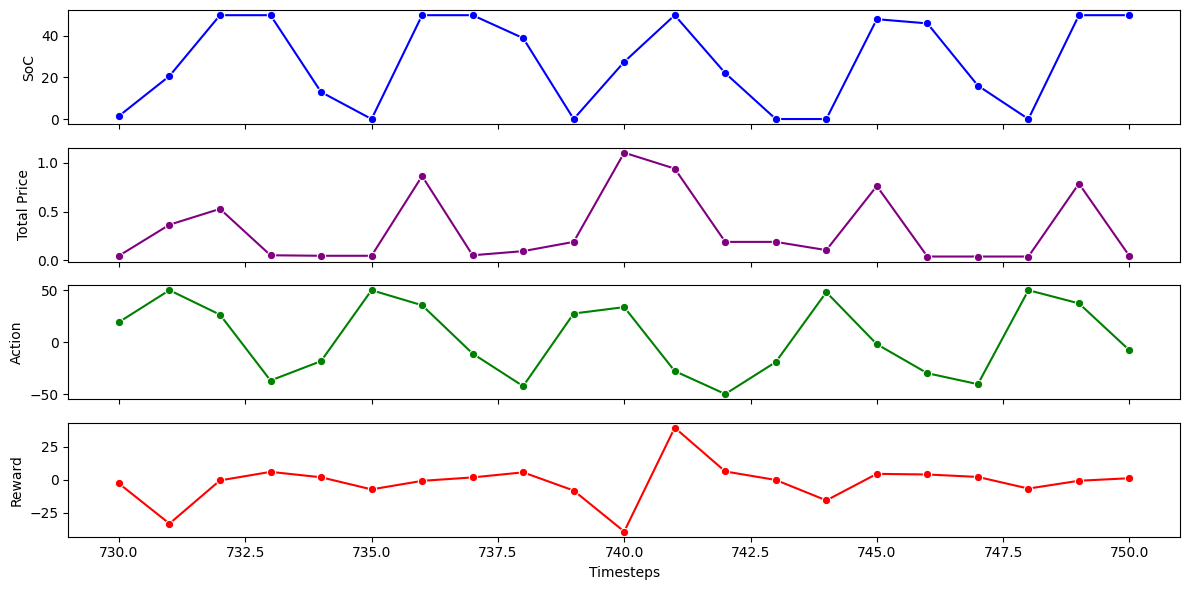

In [10]:
for agent in ["ppo", "a2c", "sac"]:
    print(f"Agent: {agent}")
    for ratio in ["0.1", "0.5", "0.9"]:
        print(f"\tRatio: {ratio}")
        df = pd.read_csv(f"logs/{agent.upper()}/{ratio}/true_market_simulation.csv", index_col=0)
        calc_reward(df)
        calc_battery_util(df)
        plot_behaviour(df, start=730, end=750, episode=5)
        break
    break

In [2]:
import pandas as pd
df = pd.read_csv("logs/A2C/base_env_eval.csv", index_col=0)
df.groupby('episode').sum()['reward']

episode
1     5169.462642
2     5861.613071
3     5844.927892
4     5924.537233
5     6022.019825
6     6038.423156
7     6022.860752
8     5666.349973
9     6434.222808
10    6506.571681
Name: reward, dtype: float64

In [3]:
calc_reward(df)

NameError: name 'calc_reward' is not defined

In [4]:
df[df['episode'] == 1][df.step >=4800][df.step < 4820] #.plot(x='step', y='reward')

/tmp/ipykernel_1084410/1246259137.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['episode'] == 1][df.step >=4800][df.step < 4820] #.plot(x='step', y='reward')


IndexError: indices are out-of-bounds